# Exploratory Data Analysis for Kaggle's Annotated Corpus

This notebook documents the data lineage and exploratory data analysis (EDA) for Kaggle's [Annotated Corpus for Named Entity Recognition](https://www.kaggle.com/datasets/abhinavwalia95/entity-annotated-corpus) (NER) dataset, which is a tagged and annotated version of the [Groningen Meaning Bank](https://gmb.let.rug.nl/) (GMB) dataset.

## Setup

Import modules:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

There are 2 CSV files in this dataset. Let's load them in:

In [2]:
ner = pd.read_csv('/Users/julia/Datasets/ner_corpus/ner.csv', 
    index_col=0, encoding='latin1', on_bad_lines='warn', low_memory=False)
ner_dataset = pd.read_csv('/Users/julia/Datasets/ner_corpus/ner_dataset.csv', 
    encoding='latin1', on_bad_lines='warn', low_memory=False)

b'Skipping line 281837: expected 25 fields, saw 34\n'


The first 5 lines of `ner`:

In [3]:
ner.head(5)

,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,pos,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,NNS,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,IN,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,NNS,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,VBP,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,march,through,london,NNP,capitalized,London,IN,lowercase,through,VBN,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


The first 30 lines of `ner_dataset`:

In [4]:
ner_dataset.head(30)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


The remainder of this notebook will be the exploration of the `ner_dataset` table; we will investigate `ner` in a separate notebook.

We can see that each row contains 1 word or punctuation mark. The `Sentence #` column marks the beginning of each sentence. The `POS` column contains part-of-speech tags (see [alphabetical list of POS tags](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html)).

The `Tag` column contains entity tags (see [dataset glossary](https://dax-cdn.cdn.appdomain.cloud/dax-groningen-meaning-bank-modified/1.0.2/data-preview/index.html)):
- **geo** = Geographical Entity (such as a location)
- **org** = Organization
- **per** = Person
- **gpe** = Geopolitical Entity (geographical regions defined by political/social groups)
- **tim** = Time (such as days of the week and months of a year)
- **art** = Artifact (manmade objects, including buildings, art, and scientific theories)
- **eve** = Event (incidents and occasions that occur during a particular time)
- **nat** = Natural Object (entities that occur naturally, like diseases, biological entities, and living things)
- **O** = Other

The entity types are preceded by a `B-` or `I-` tag, the former indicates the first (or only) term of an entity, whereas the latter indicates subsequent terms in an entity. For example, "New York" is an entity with 2 terms.

The `Tag` column would be our target attribute for supervised learning (NER task).

## Train-Test Split

Check the number of sentences in the table:

In [5]:
print(f"There are {len(ner_dataset):,} rows and {ner_dataset['Sentence #'].notnull().sum():,} sentences in the table.")

There are 1,048,575 rows and 47,959 sentences in the table.


Let's split the data into training and test sets (80:20). First, we'll find the row number corresponding to 80% of the rows, and look forward by 10 rows so that we don't truncate a sentence. Then, we'll split up the dataset by the nearest whole sentence.

In [6]:
cutoff_80 = int(len(ner_dataset) * 0.8)

ner_dataset.iloc[cutoff_80:cutoff_80 + 10]

,Sentence #,Word,POS,Tag
838860,NaN,747s,NNS,O
838861,NaN,.,.,O
838862,Sentence: 38347,They,PRP,O
838863,NaN,were,VBD,O
838864,NaN,successful,JJ,O
838865,NaN,in,IN,O
838866,NaN,getting,VBG,O
838867,NaN,it,PRP,O
838868,NaN,out,IN,O
838869,NaN,of,IN,O


In [7]:
train = ner_dataset[:838862]
test = ner_dataset[838862:]

len(train) / len(ner_dataset), len(test) / len(ner_dataset)

(0.8000019073504518, 0.1999980926495482)

We'll set aside the test set and only examine the training set moving forward.

## EDA

Let's use `pandas-profiling` ([docs](https://pandas-profiling.ydata.ai/docs/master/index.html)) to automatically generate a report:

In [17]:
profile = ProfileReport(train, title='Pandas Profiling Report: ner_dataset train set')
# profile.to_notebook_iframe()
profile.to_file('ner_dataset.html')

/usr/local/Caskroom/miniconda/base/envs/fbenv/lib/python3.9/site-packages/multimethod/__init__.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self[tuple(map(self.get_type, args))](*args, **kwargs)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

To view the report, you can use `profile.to_notebook_iframe()` above (currently commented-out because it doesn't render well on GitHub) or you can view the accompanying `ner_dataset.html` in the same directory as this notebook.

The results from this report are not surprising. We are expecting a lot of "missing" data in the `Sentence #` column due to the organization of the sentences.

Fortunately, there is no missing data in the `Word`, `POS`, or `Tag` columns — so we don't need to perform any NaN removal or imputation operations.

This report provides a useful breakdown of common categories for the `POS` and `Tag` columns.

Let's look at the most common values in each column:

In [9]:
train.describe()

,Sentence #,Word,POS,Tag
count,38346,838862,838862,838862
unique,38346,31806,42,17
top,Sentence: 1,the,NN,O
freq,1,42013,117013,710352


The most common word is "the," the most common part-of-speech is "NN" (singular noun), and the most common tag is "O" (other). Makes sense!

Let's look at the number of characters per word:

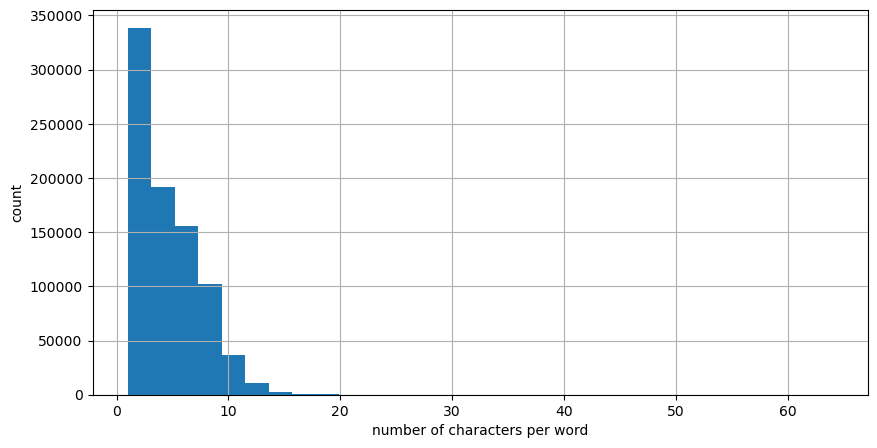

In [10]:
train['Word'].str.len().hist(figsize=(10, 5), bins=30)
plt.xlabel('number of characters per word')
plt.ylabel('count')
plt.show()

Looks like we mostly have short words with less than 5 characters. Its distribution is very skewed.

As we saw earlier, the `ner_dataset` only has sentence #s for the first word of each sentence; everything else is NaNs. Let's change that by propagating all non-null values forward and updating the data type:

In [11]:
train_prepared = train.fillna(method='ffill', axis=0)
train_prepared['Sentence #'] = train_prepared['Sentence #'].str.replace('Sentence: ', '')
train_prepared['Sentence #'] = train_prepared['Sentence #'].astype(int)
train_prepared.head(35)

,Sentence #,Word,POS,Tag
0,1,Thousands,NNS,O
1,1,of,IN,O
2,1,demonstrators,NNS,O
3,1,have,VBP,O
4,1,marched,VBN,O
5,1,through,IN,O
6,1,London,NNP,B-geo
7,1,to,TO,O
8,1,protest,VB,O
9,1,the,DT,O


Now every row has its sentence number. Let's perform a sanity check on how many missing values we have:

In [12]:
train_prepared.isna().sum()

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

Let's examine the number of words per sentence:

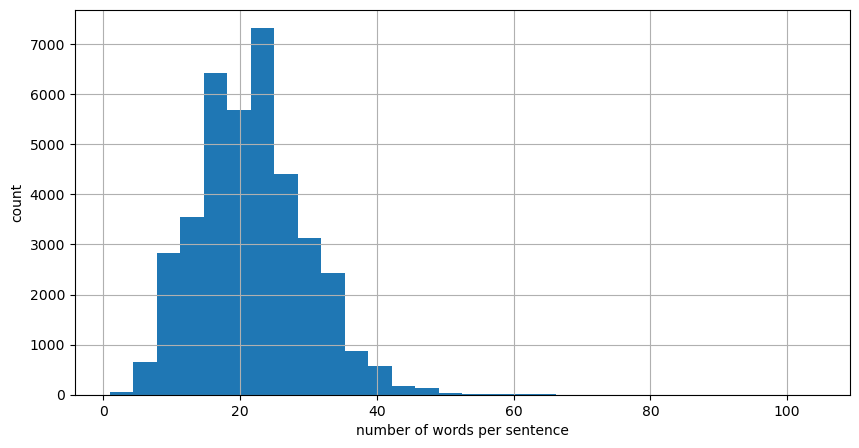

In [13]:
train_prepared.groupby('Sentence #')['Word'].count().hist(figsize=(10, 5), bins=30)
plt.xlabel('number of words per sentence')
plt.ylabel('count')
plt.show()

Looks like the distribution is fairly symmetrical, with ~20 words on average per sentence.

Every word is on its own row, so let's re-form whole sentences and put them in a list (which we'll use as input for the modeling step; see next section below).

Re-form whole sentences, and print out the first three:

In [14]:
train_sentences = train_prepared.groupby('Sentence #')['Word'].apply(lambda x: ' '.join(x))
train_sentences.iloc[0], train_sentences.iloc[1], train_sentences.iloc[2]

('Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .',
 'Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . "',
 'They marched from the Houses of Parliament to a rally in Hyde Park .')

Remove the space before periods:

In [15]:
train_sentences = train_sentences.str.replace(' .', '.', regex=False)
train_sentences.iloc[0], train_sentences.iloc[1], train_sentences.iloc[2]

('Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country.',
 'Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings. "',
 'They marched from the Houses of Parliament to a rally in Hyde Park.')

Convert from a pandas.Series to a list:

In [16]:
list_of_sentences = train_sentences.tolist()
list_of_sentences[0], list_of_sentences[1], list_of_sentences[2]

('Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country.',
 'Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings. "',
 'They marched from the Houses of Parliament to a rally in Hyde Park.')

## Next Steps

From this EDA, it is clear that we can use the `ner_dataset` table to train or fine-tune a model for NER tasks, which is one of the goals of our capstone project.

Our next step would be to establish an ML modeling baseline for this dataset using a pre-trained model. We plan to use the HuggingFace Transformers library's `pipeline` object ([documentation](https://huggingface.co/docs/transformers/main_classes/pipelines)), which is a simple API that will allow us to quickly establish a model baseline.



Here is an example of its usage:

In [ ]:
from transformers import pipeline

pipe = pipeline('ner', grouped_entities=True)
pipe('...text goes here...')

Note that `ner` is an alias for `token-classification` in the Transformers library. Alternatively, instead of `pipeline` we can directly call `TokenClassificationPipeline` ([documentation](https://huggingface.co/docs/transformers/v4.24.0/en/main_classes/pipelines#transformers.TokenClassificationPipeline)).

Optionally, we can specify a pre-trained model in the `pipeline` command above.

Since we want to call `pipeline` on multiple sentences, one option is to aggregate the sentences into a list.

Here's an example for 2 sentences:

In [ ]:
pipe(['This is sentence one.', 'This is sentence two.'])

All pipelines can use batching, including when we pass lists.

This is what the syntax would look like:

In [ ]:
for out in pipe(list_of_sentences, batch_size=8):
    print(out)

Once we have the outputs from the model for all of the sentences in our corpus, we can evaluate its performance when compared with the dataset's labels in the `Tag` column.